# k-Means Clustering

Previously, we explored unsupervised machine learning models for dimensionality reduction.
Now we will move on to another class of unsupervised machine learning models: clustering algorithms.
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in `sklearn.cluster.KMeans`.

We begin with the standard imports:

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import numpy as np

## Introducing k-Means

The *k*-means algorithm searches for a predetermined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The *cluster center* is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization (see the following figure):

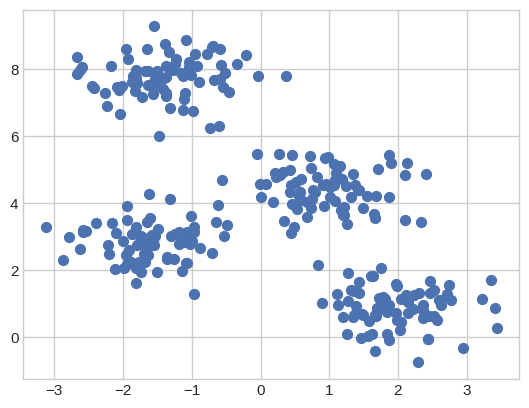

In [5]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [6]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels (the following figure).
We will also plot the cluster centers as determined by the *k*-means estimator:

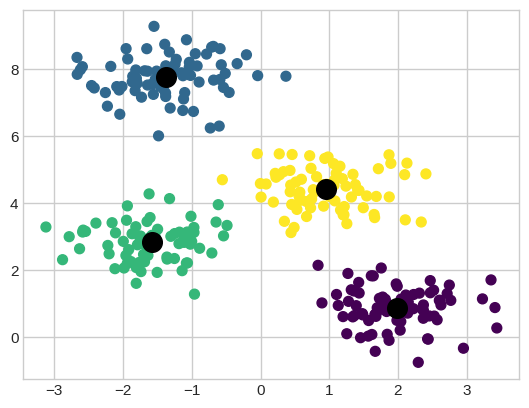

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly: after all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers.
2. Repeat until converged:
   1. *E-step*: Assign points to the nearest cluster center.
   2. *M-step*: Set the cluster centers to the mean of their assigned points.

Here the *E-step* or *expectation step* is so named because it involves updating our expectation of which cluster each point belongs to.
The *M-step* or *maximization step* is so named because it involves maximizing some fitness function that defines the locations of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.


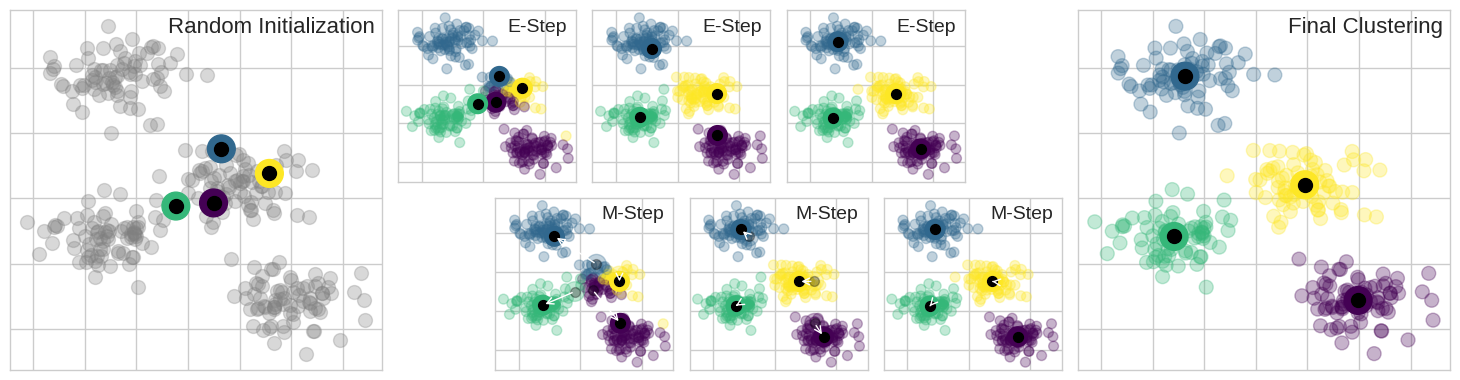

In [8]:
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin

X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

rng = np.random.RandomState(42)
centers = [0, 4] + rng.randn(4, 2)

def draw_points(ax, c, factor=1):
    ax.scatter(X[:, 0], X[:, 1], c=c, s=50 * factor, alpha=0.3, cmap = 'viridis' if type(c) != str else None)
    
def draw_centers(ax, centers, factor=1, alpha=1.0):
    ax.scatter(centers[:, 0], centers[:, 1],
               c=np.arange(4), cmap='viridis', s=200 * factor,
               alpha=alpha)
    ax.scatter(centers[:, 0], centers[:, 1],
               c='black', s=50 * factor, alpha=alpha)

def make_ax(fig, gs):
    ax = fig.add_subplot(gs)
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    return ax

fig = plt.figure(figsize=(15, 4))
gs = plt.GridSpec(4, 15, left=0.02, right=0.98, bottom=0.05, top=0.95, wspace=0.2, hspace=0.2)
ax0 = make_ax(fig, gs[:4, :4])
ax0.text(0.98, 0.98, "Random Initialization", transform=ax0.transAxes,
         ha='right', va='top', size=16)
draw_points(ax0, 'gray', factor=2)
draw_centers(ax0, centers, factor=2)

for i in range(3):
    ax1 = make_ax(fig, gs[:2, 4 + 2 * i:6 + 2 * i])
    ax2 = make_ax(fig, gs[2:, 5 + 2 * i:7 + 2 * i])
    
    # E-step
    y_pred = pairwise_distances_argmin(X, centers)
    draw_points(ax1, y_pred)
    draw_centers(ax1, centers)
    
    # M-step
    new_centers = np.array([X[y_pred == i].mean(0) for i in range(4)])
    draw_points(ax2, y_pred)
    draw_centers(ax2, centers, alpha=0.3)
    draw_centers(ax2, new_centers)
    for i in range(4):
        ax2.annotate('', new_centers[i], centers[i],
                     arrowprops=dict(arrowstyle='->', linewidth=1))
        
    
    # Finish iteration
    centers = new_centers
    ax1.text(0.95, 0.95, "E-Step", transform=ax1.transAxes, ha='right', va='top', size=14)
    ax2.text(0.95, 0.95, "M-Step", transform=ax2.transAxes, ha='right', va='top', size=14)


# Final E-step    
y_pred = pairwise_distances_argmin(X, centers)
axf = make_ax(fig, gs[:4, -4:])
draw_points(axf, y_pred, factor=2)
draw_centers(axf, centers, factor=2)
axf.text(0.98, 0.98, "Final Clustering", transform=axf.transAxes,
         ha='right', va='top', size=16)


fig.savefig('images/05.11-expectation-maximization.png')

The following script uses IPython's interactive widgets to demonstrate the K-means algorithm interactively. Run this within the IPython notebook to explore the expectation maximization algorithm for computing K Means.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()  # for plot styling
import numpy as np

from ipywidgets import interact
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import make_blobs

def plot_kmeans_interactive(min_clusters=1, max_clusters=6):
    X, y = make_blobs(n_samples=300, centers=4,
                      random_state=0, cluster_std=0.60)
        
    def plot_points(X, labels, n_clusters):
        plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis',
                    vmin=0, vmax=n_clusters - 1);
            
    def plot_centers(centers):
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c=np.arange(centers.shape[0]),
                    s=200, cmap='viridis')
        plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c='black', s=50)
            

    def _kmeans_step(frame=0, n_clusters=4):
        rng = np.random.RandomState(2)
        labels = np.zeros(X.shape[0])
        centers = rng.randn(n_clusters, 2)

        nsteps = frame // 3

        for i in range(nsteps + 1):
            old_centers = centers
            if i < nsteps or frame % 3 > 0:
                labels = pairwise_distances_argmin(X, centers)

            if i < nsteps or frame % 3 > 1:
                centers = np.array([X[labels == j].mean(0) if len(X[labels==j]) > 0 else centers[j] for j in range(n_clusters)])
                #centers = np.array([X[labels == j].mean(0)
                #                    for j in range(n_clusters)])
                nans = np.isnan(centers)
                centers[nans] = old_centers[nans]

        # plot the data and cluster centers
        plot_points(X, labels, n_clusters)
        plot_centers(old_centers)

        # plot new centers if third frame
        if frame % 3 == 2:
            for i in range(n_clusters):
                plt.annotate('', centers[i], old_centers[i], 
                             arrowprops=dict(arrowstyle='->', linewidth=1))
            plot_centers(centers)

        plt.xlim(-4, 4)
        plt.ylim(-2, 10)

        if frame % 3 == 1:
            plt.text(3.8, 9.5, "E. REASSIGN CENTROID",
                     ha='right', va='top', size=14)
        elif frame % 3 == 2:
            plt.text(3.8, 9.5, "M. UPDATE CENTROIDS",
                     ha='right', va='top', size=14)
        plt.show()
        
    
    return interact(_kmeans_step, frame=(0, 100),
                    n_clusters=(min_clusters, max_clusters+1))

plot_kmeans_interactive();

interactive(children=(IntSlider(value=0, description='frame'), IntSlider(value=4, description='n_clusters', ma…

The *k*-means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation (see the following figure):

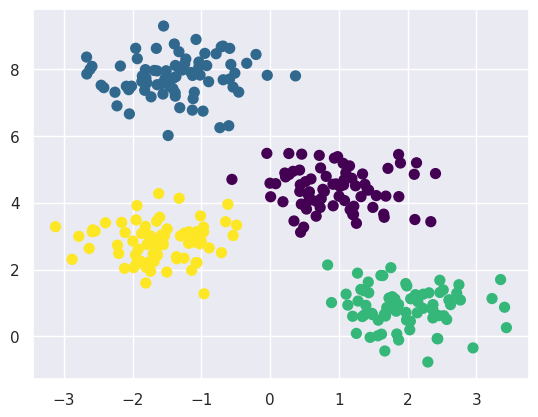

In [10]:
%matplotlib inline
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]

    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)

        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])

        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers

    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

There are a few caveats to be aware of when using the expectation–maximization algorithm:

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results (see the following figure):

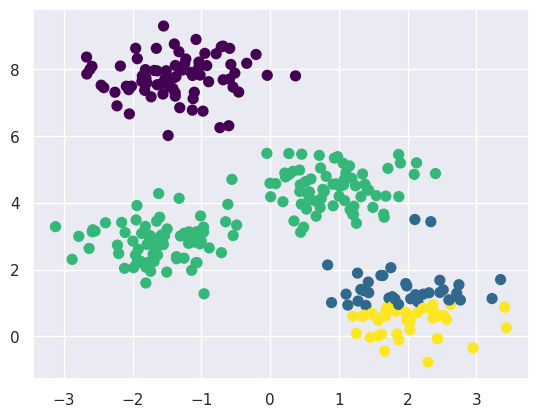

In [16]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (the number is set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

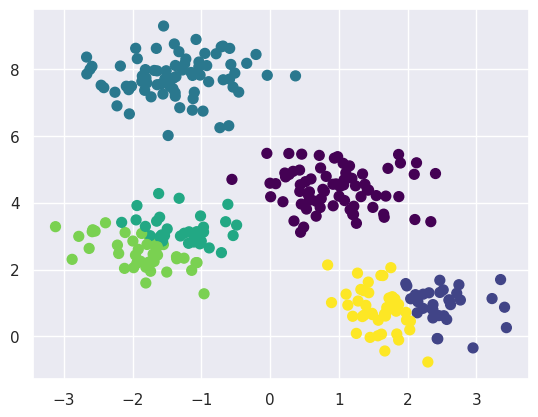

In [17]:
km_model = KMeans(6, random_state=0)
labels = km_model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

**Decision Boundaries**

Let's plot the model's decision boundaries. This gives us a _Voronoi diagram_:

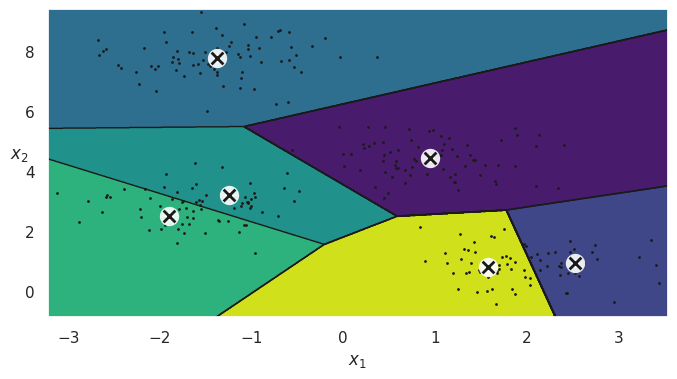

In [18]:
# extra code – this cell generates and saves Figure 9–3

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="viridis") #"Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(km_model, X)
plt.savefig('images/voronoi_plot.png')
plt.show()


Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm that has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [Gaussian Mixture Models](Gaussian_Mixtures.ipynb)) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the `sklearn.cluster` submodule).

### Silhoutte Analysis

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In this example the silhouette analysis is used to choose an optimal value for n_clusters. The silhouette plot shows that the n_clusters value of 3, 5 and 6 are a bad pick for the given data due to the presence of clusters with below average silhouette scores and also due to wide fluctuations in the size of the silhouette plots. Silhouette analysis is more ambivalent in deciding between 2 and 4.

Also from the thickness of the silhouette plot the cluster size can be visualized. The silhouette plot for cluster 0 when n_clusters is equal to 2, is bigger in size owing to the grouping of the 3 sub clusters into one big cluster. However when the n_clusters is equal to 4, all the plots are more or less of similar thickness and hence are of similar sizes as can be also verified from the labelled scatter plot on the right.

For n_clusters = 2 The average silhouette_score is : 0.5426422297358302


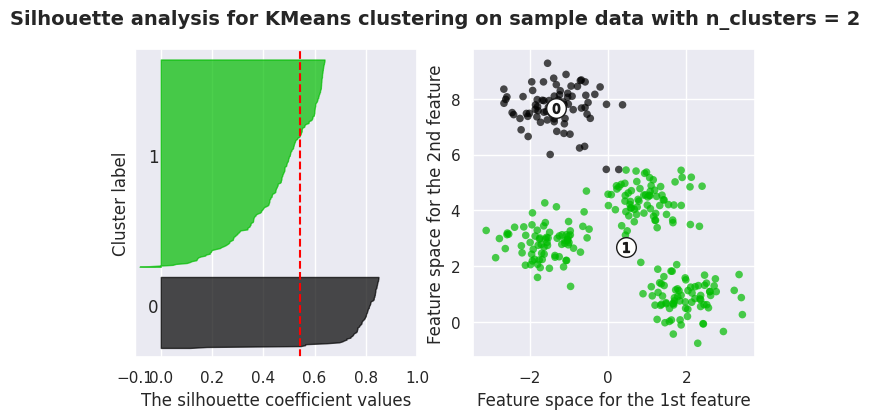

For n_clusters = 3 The average silhouette_score is : 0.5890390393551768


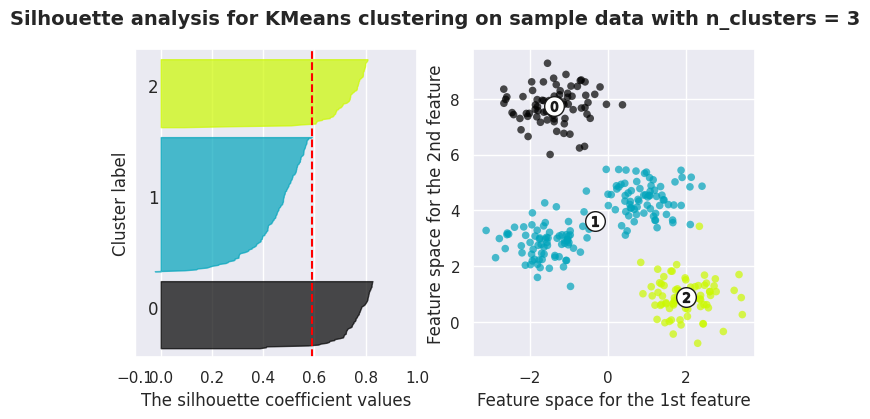

For n_clusters = 4 The average silhouette_score is : 0.6819938690643478


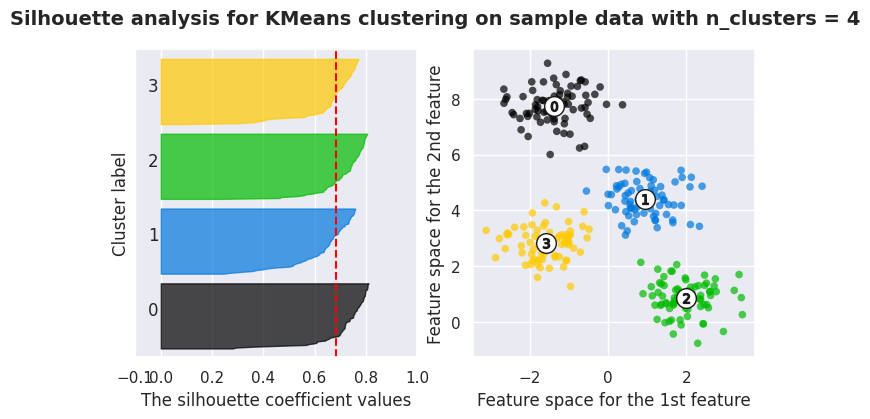

For n_clusters = 5 The average silhouette_score is : 0.5923875148758644


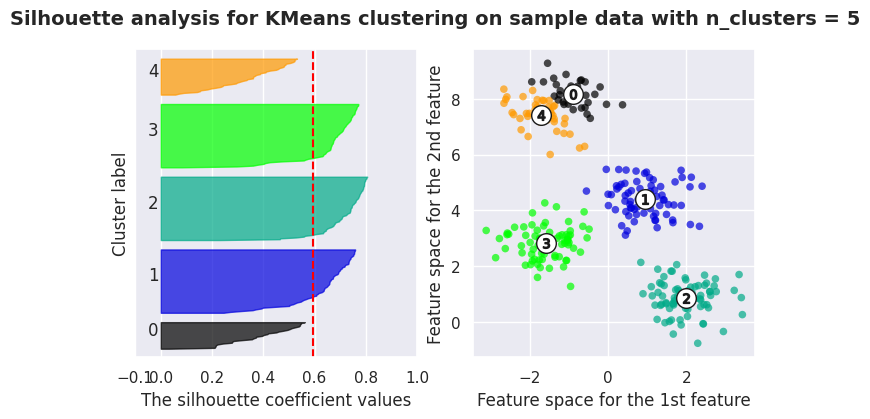

For n_clusters = 6 The average silhouette_score is : 0.49219490077023903


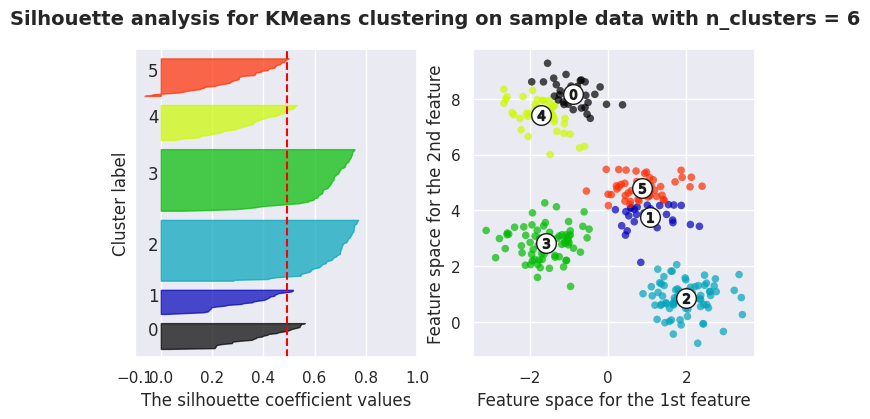

In [19]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    #ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

    plt.show()

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach (see the following figure):

In [20]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

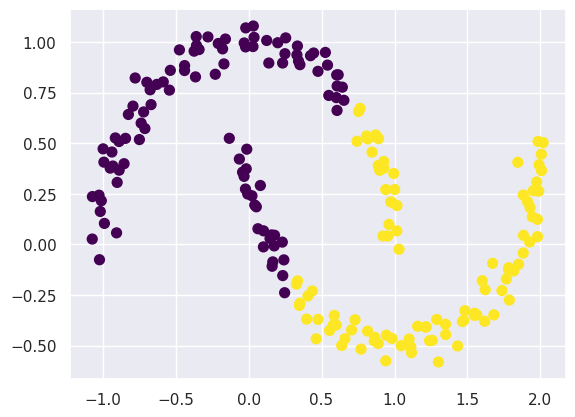

In [22]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

This situation is reminiscent of the discussion in [Support Vector Machines](SVM.ipynb), where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm (see the following figure):

/store/venv/da5401/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


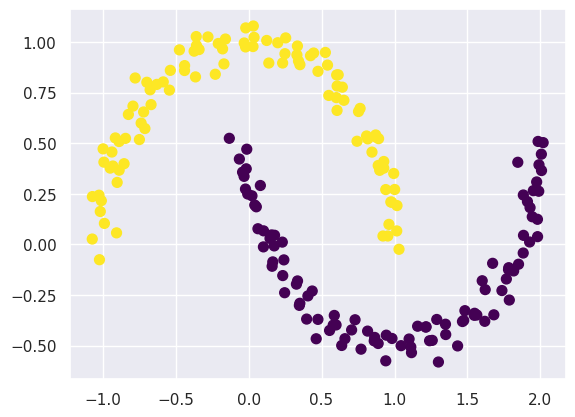

In [24]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

#### k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`.
The interface for this is the same as for standard `KMeans`; we will see an example of its use as we continue our discussion.

__Accelerated K-Means__

The K-Means algorithm can sometimes be accelerated by avoiding many unnecessary distance calculations: this is achieved by exploiting the triangle inequality (given three points A, B and C, the distance AC is always such that AC ≤ AB + BC) and by keeping track of lower and upper bounds for distances between instances and centroids (see this [2003 paper](https://www.aaai.org/Papers/ICML/2003/ICML03-022.pdf) by Charles Elkan for more details).

For Elkan's variant of K-Means, use `algorithm="elkan"`. For regular KMeans, use `algorithm="full"`. The default is `"auto"`, which uses the full algorithm since Scikit-Learn 1.1 (it used Elkan's algorithm before that).

### Mini-Batch K-Means

Scikit-Learn also implements a variant of the K-Means algorithm that supports mini-batches (see [this paper](http://www.eecs.tufts.edu/~dsculley/papers/fastkmeans.pdf)):

In [25]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)
minibatch_kmeans.fit(X)

MiniBatchKMeans(n_clusters=5, n_init=3, random_state=42)

Note: Throughout this notebook, when `n_init` was not set when creating a `MiniBatchKMeans` estimator, I explicitly set it to `n_init=3` to avoid a warning about the fact that the default value for this hyperparameter will change from 3 to `"auto"` in Scikit-Learn 1.4.

In [26]:
minibatch_kmeans.inertia_

26.640495147109956

**Using `MiniBatchKMeans` along with `memmap`** (not in the book)

If the dataset does not fit in memory, the simplest option is to use the `memmap` class, just like we did for incremental PCA in the previous chapter. First let's load MNIST:

In [27]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")

Let's split the dataset:

In [28]:
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

Next, let's write the training set to a `memmap`:

In [29]:
filename = "my_mnist.mmap"
X_memmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_memmap[:] = X_train
X_memmap.flush()

In [30]:
from sklearn.cluster import MiniBatchKMeans

minibatch_kmeans = MiniBatchKMeans(n_clusters=10, batch_size=10, n_init=3, random_state=42)
minibatch_kmeans.fit(X_memmap)

MiniBatchKMeans(batch_size=10, n_clusters=10, n_init=3, random_state=42)

Let's plot the inertia ratio and the training time ratio between Mini-batch K-Means and regular K-Means:

  0%|          | 0/50 [00:00<?, ?it/s]

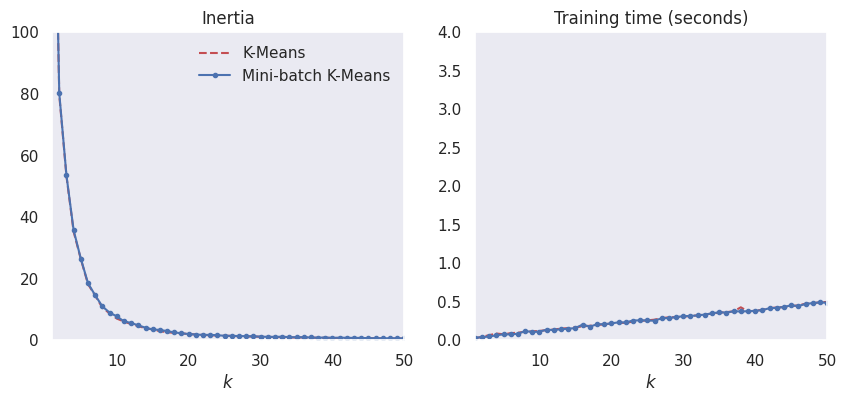

In [38]:
from timeit import timeit
from tqdm.auto import tqdm

max_k = 50
times = np.empty((max_k, 2))
inertias = np.empty((max_k, 2))
for k in tqdm(range(1, max_k + 1)):
    kmeans_ = KMeans(n_clusters=k, algorithm="lloyd", n_init=10, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, n_init=10, random_state=42)

    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(range(1, max_k + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Inertia")
plt.legend()
plt.axis([1, max_k, 0, 100])
plt.grid()

plt.subplot(122)
plt.plot(range(1, max_k + 1), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, max_k + 1), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$")
plt.title("Training time (seconds)")
plt.axis([1, max_k, 0, 4])
plt.grid()

plt.savefig("images/minibatch_kmeans_vs_kmeans_plot")
plt.show()

### Finding the optimal number of clusters

What if the number of clusters was set to a lower or greater value than 5?

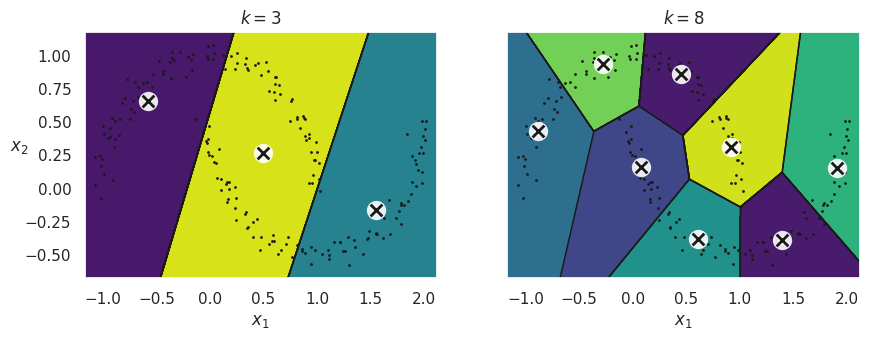

In [40]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None,
                              title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2)

kmeans_k3 = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans_k8 = KMeans(n_clusters=8, n_init=10, random_state=42)

plot_clusterer_comparison(kmeans_k3, kmeans_k8, X, "$k=3$", "$k=8$")
plt.savefig("images/bad_n_clusters_plot")
plt.show()

Ouch, these two models don't look great. What about their inertias?

In [41]:
kmeans_k3.inertia_

53.28989388536144

In [42]:
kmeans_k8.inertia_

10.574075527298525

No, we cannot simply take the value of $k$ that minimizes the inertia, since it keeps getting lower as we increase $k$. Indeed, the more clusters there are, the closer each instance will be to its closest centroid, and therefore the lower the inertia will be. However, we can plot the inertia as a function of $k$ and analyze the resulting curve:

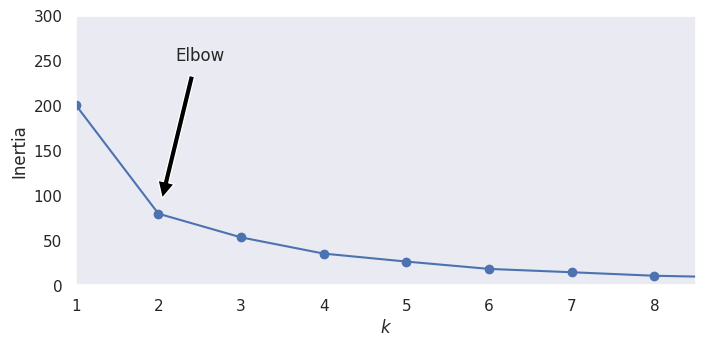

In [54]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$")
plt.ylabel("Inertia")
plt.annotate("", xy=(2, inertias[1]), xytext=(2.45, 250), arrowprops=dict(facecolor='black', shrink=0.1))
plt.text(2.5, 250, "Elbow", horizontalalignment="center")
plt.axis([1, 8.5, 0, 300])
plt.grid()
plt.savefig("images/inertia_vs_k_plot")
plt.show()

As you can see, there is an elbow at $k=2$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half. So $k=2$ is a pretty good choice. Of course in this example it is not perfect since it means that the two blobs in the lower left will be considered as just a single cluster, but it's a pretty good clustering nonetheless.

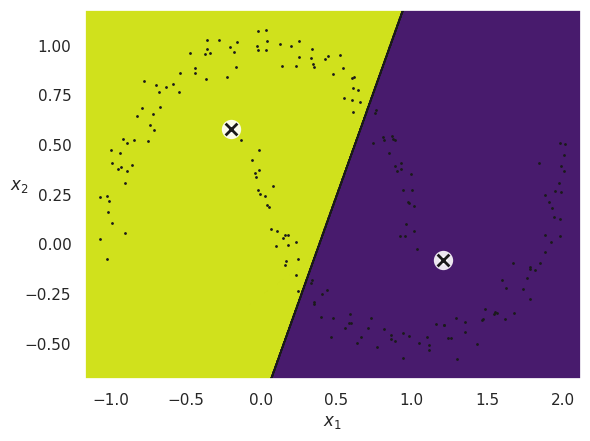

In [57]:
# extra code
plot_decision_boundaries(kmeans_per_k[2 - 1], X)
plt.show()

## DBSCAN

The [DBSCAN](http://scikit-learn.org/stable/modules/clustering.html#dbscan) algorithm views clusters as areas of high density separated by areas of low density.

Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped.

The central component to the DBSCAN is the **concept of core samples, which are samples that are in areas of high density**. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples).

![dbscan](https://3.bp.blogspot.com/-rDYuyg00Z0w/WXA-OQpkAfI/AAAAAAAAI_I/QshfNVNHD_wXJwXEipRIVzDSX5iOEAy2wCEwYBhgL/s1600/DBSCAN_Points.PNG)

In [112]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

DBSCAN(eps=0.05)

In [63]:
dbscan.labels_[:10]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5])

In [64]:
dbscan.core_sample_indices_[:10]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13])

In [65]:
dbscan.components_

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       ...,
       [ 1.66258462, -0.3079193 ],
       [-0.94355873,  0.3278936 ],
       [ 0.79419406,  0.60777171]])

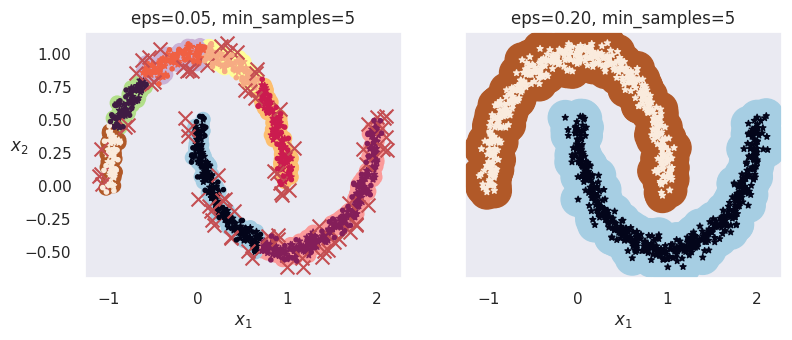

In [66]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20,
                c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1],
                c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}")
    plt.grid()
    plt.gca().set_axisbelow(True)

dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.savefig("dbscan_plot")
plt.show()

In [67]:
dbscan = dbscan2  # extra code – the text says we now use eps=0.2

In [68]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

In [69]:
X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(X_new)

array([1, 0, 1, 0])

In [70]:
knn.predict_proba(X_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

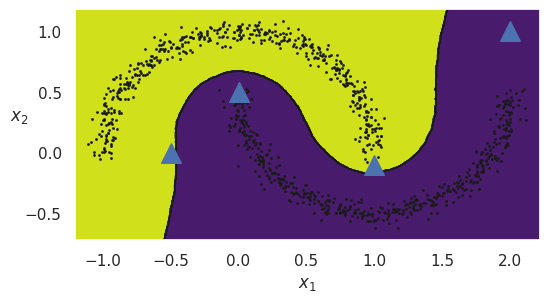

In [75]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(X_new[:, 0], X_new[:, 1], c="b", marker="^", s=200, zorder=10)
plt.savefig("images/cluster_classification_plot")
plt.show()

In [76]:
y_dist, y_pred_idx = knn.kneighbors(X_new, n_neighbors=1)
y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] = -1
y_pred.ravel()

array([-1,  0,  1, -1])

## How does DBSCAN perform?

In [98]:
from sklearn import cluster, datasets
n_samples = 1500
noisy_circles,circle_labels = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons,moon_labels = datasets.make_moons(n_samples=n_samples, noise=.1)

dbs = cluster.DBSCAN(eps=0.1)
dbs.fit(noisy_moons)

DBSCAN(eps=0.1)

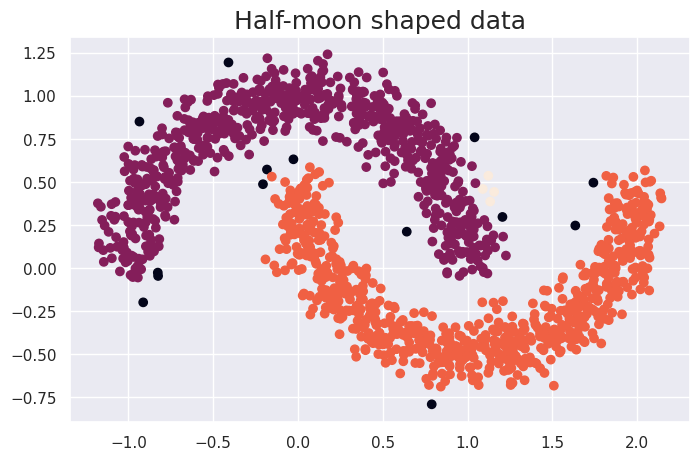

In [99]:
plt.figure(figsize=(8,5))
plt.title("Half-moon shaped data", fontsize=18)
plt.grid(True)
plt.scatter(noisy_moons[:,0],noisy_moons[:,1],c=dbs.labels_)
plt.show()

In [100]:
dbs.fit(noisy_circles)

DBSCAN(eps=0.1)

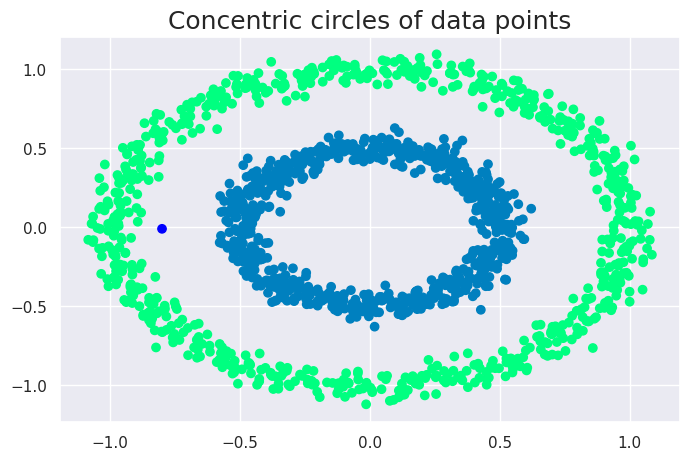

In [103]:
plt.figure(figsize=(8,5))
plt.title("Concentric circles of data points", fontsize=18)
plt.grid(True)
plt.scatter(noisy_circles[:,0],noisy_circles[:,1],c=dbs.labels_, cmap='winter')
plt.show()

## Other Clustering Algorithms

### Spectral Clustering

In [116]:
from sklearn.cluster import SpectralClustering

In [117]:
sc1 = SpectralClustering(n_clusters=2, gamma=10, random_state=42)
sc1.fit(X)

SpectralClustering(gamma=10, n_clusters=2, random_state=42)

In [118]:
sc1.affinity_matrix_.round(2)

array([[1.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.89, ..., 0.01, 0.  , 0.  ],
       [0.  , 0.89, 1.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.01, 0.  , ..., 1.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ]])

In [119]:
sc2 = SpectralClustering(n_clusters=2, gamma=1, random_state=42)
sc2.fit(X)

SpectralClustering(gamma=1, n_clusters=2, random_state=42)

In [120]:
def plot_spectral_clustering(sc, X, size, alpha, show_xlabels=True,
                             show_ylabels=True):
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=size, c='gray', alpha=alpha)
    plt.scatter(X[:, 0], X[:, 1], marker='o', s=30, c='w')
    plt.scatter(X[:, 0], X[:, 1], marker='.', s=10, c=sc.labels_, cmap="Paired")
    
    if show_xlabels:
        plt.xlabel("$x_1$")
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title(f"RBF gamma={sc.gamma}")

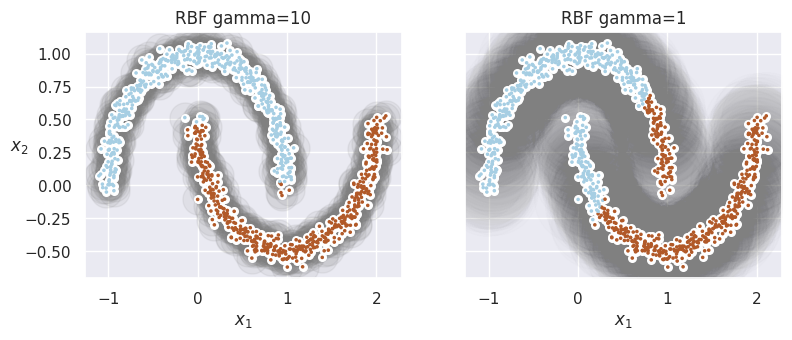

In [121]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_spectral_clustering(sc1, X, size=500, alpha=0.1)

plt.subplot(122)
plot_spectral_clustering(sc2, X, size=4000, alpha=0.01, show_ylabels=False)

plt.show()

# Hierarchical Clustering

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering, Divisive and Agglomerative.

**Divisive method**: In this method we assign all of the observations to a single cluster and then partition the cluster to two least similar clusters. Finally, we proceed recursively on each cluster until there is one cluster for each observation.

**Agglomerative method**: In this method we assign each observation to its own cluster. Then, compute the similarity (e.g., distance) between each of the clusters and join the two most similar clusters. Finally, repeat steps 2 and 3 until there is only a single cluster left.

## Linkage or distance matrix

Before any clustering is performed, it is required to determine the proximity matrix containing the distance between each point using a distance function. Then, the matrix is updated to display the distance between each cluster. The following three methods differ in how the distance between each cluster is measured.

**Single Linkage**: In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two closest points.

<img src=http://www.saedsayad.com/images/Clustering_single.png>

**Complete Linkage**: In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” to the left is equal to the length of the arrow between their two furthest points.

<img src=http://www.saedsayad.com/images/Clustering_complete.png>

**Average Linkage**: In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” to the left is equal to the average length each arrow between connecting the points of one cluster to the other.

<img src=http://www.saedsayad.com/images/Clustering_average.png>

## Dendograms

[Dendograms](https://en.wikipedia.org/wiki/Dendrogram) are tree diagrams frequently used to illustrate the arrangement of the clusters produced by hierarchical clustering. The clades are arranged according to how similar (or dissimilar) they are. Clades that are close to the same height are similar to each other; clades with different heights are dissimilar — the greater the difference in height, the more dissimilarity. 

An example involving the famous Iris data set is shown below.

<img src=https://upload.wikimedia.org/wikipedia/commons/1/12/Iris_dendrogram.png height='400px' width = '400px'>

# Clustering with a shopping trend data set

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Read in the data set

In [141]:
df = pd.read_csv('Mall_Customers.csv')
df.head(10)

CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
5           6  Female   22                  17                      76
6           7  Female   35                  18                       6
7           8  Female   23                  18                      94
8           9    Male   64                  19                       3
9          10  Female   30                  19                      72

In [142]:
df.describe()

CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000

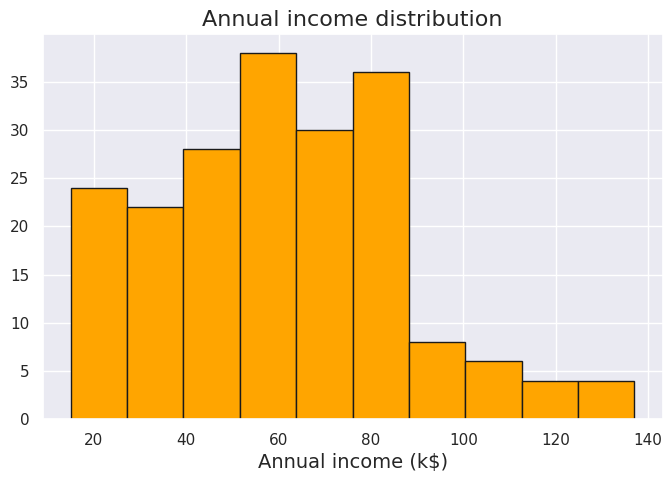

In [143]:
plt.figure(figsize=(8,5))
plt.title("Annual income distribution",fontsize=16)
plt.xlabel ("Annual income (k$)",fontsize=14)
plt.grid(True)
plt.hist(df['Annual Income (k$)'],color='orange',edgecolor='k')
plt.show()

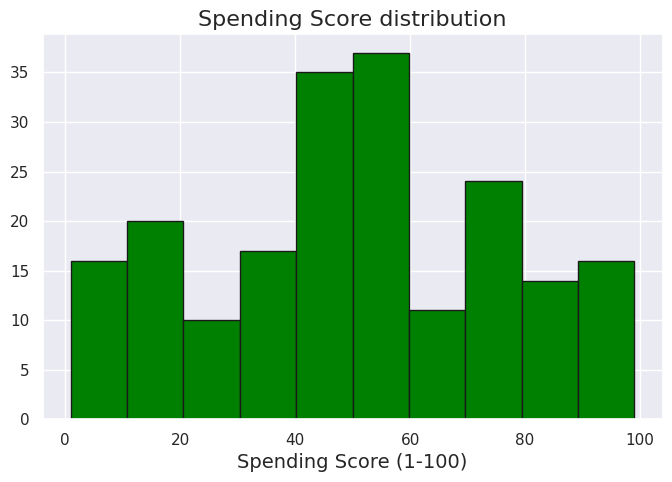

In [144]:
plt.figure(figsize=(8,5))
plt.title("Spending Score distribution",fontsize=16)
plt.xlabel ("Spending Score (1-100)",fontsize=14)
plt.grid(True)
plt.hist(df['Spending Score (1-100)'],color='green',edgecolor='k')
plt.show()

### So, is there a definitive correlation between annual income and spending score? - *Apparently not*

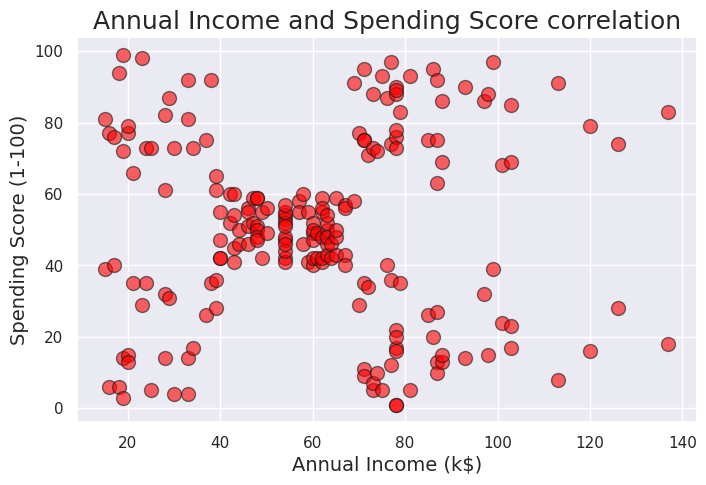

In [145]:
plt.figure(figsize=(8,5))
plt.title("Annual Income and Spending Score correlation",fontsize=18)
plt.xlabel ("Annual Income (k$)",fontsize=14)
plt.ylabel ("Spending Score (1-100)",fontsize=14)
plt.grid(True)
plt.scatter(df['Annual Income (k$)'],df['Spending Score (1-100)'],color='red',edgecolor='k',alpha=0.6, s=100)
plt.show()

### How about correlation between age and spending score? - *Apparently not*

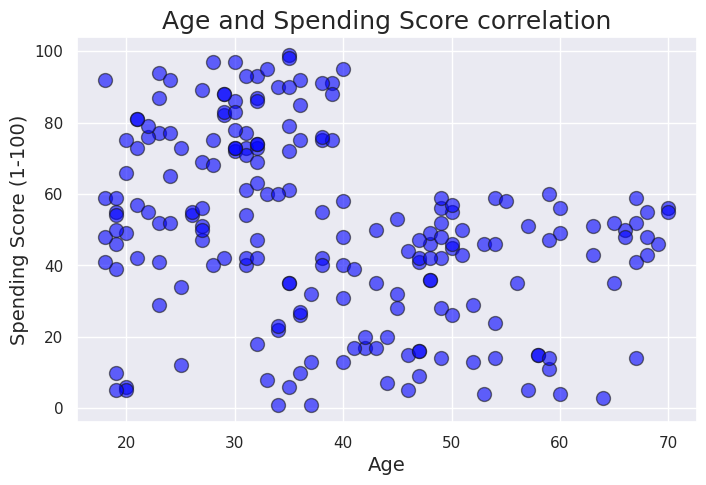

In [146]:
plt.figure(figsize=(8,5))
plt.title("Age and Spending Score correlation",fontsize=18)
plt.xlabel ("Age",fontsize=14)
plt.ylabel ("Spending Score (1-100)",fontsize=14)
plt.grid(True)
plt.scatter(df['Age'],df['Spending Score (1-100)'],color='blue',edgecolor='k',alpha=0.6, s=100)
plt.show()

## Strategy

**Therefore, we will explore cluserting the customers based on their annual income and spending score to see if there are distinguisbale clusters which the mall can target**

We could use k-means but we don't have any idea about the number of hidden clusters. We will see that hierarchial clustering with dendograms will give us a good insight on the optimal number of clusters.

## Dendograms

In [148]:
X = df.iloc[:,[3,4]].values

### _Ward_ distance matrix
We will use 'Ward' distance matrix for this dendogram.
$$d(u,v) = \sqrt{\frac{|v|+|s|}{T}d(v,s)^2+ \frac{|v|+|t|}{T}d(v,t)^2- \frac{|v|}{T}d(s,t)^2}$$

where **$u$** is the newly joined cluster consisting of clusters **$s$** and **$t$**, **$v$** is an unused cluster in the forest, **$T=|v|+|s|+|t|$**, and **$|*|$** is the cardinality of its argument. This is also known as the incremental algorithm.

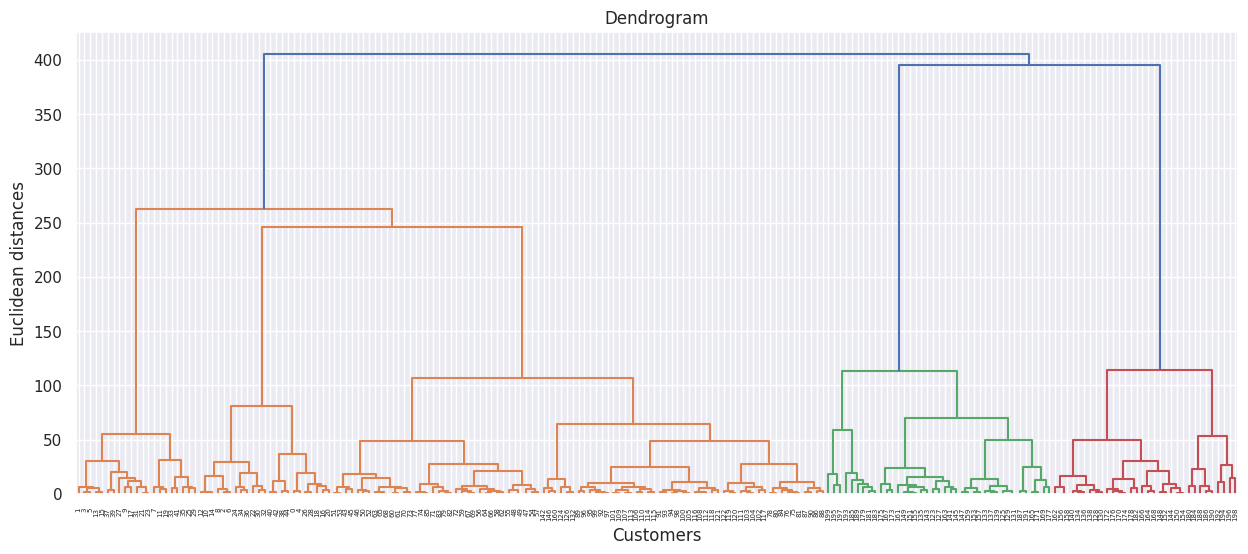

In [154]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(15,6))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.grid(True)
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.show()

### Optimal number of clusters

Often, the optimal number of clusters can be found from a Dendogram is a simple manner.
* Look for the longest stretch of vertical line which is not crossed by any ***extended*** horizontal lines (here *extended* means horizontal lines i.e. the cluster dividers are extended infinitely to both directions).
* Now take any point on that stretch of line and draw an imaginary horizontal line.
* Count how many vertical lines this imaginary lines crossed.
* That is likely to be the optimal number of clusters.

**The idea is shown in the following figure. Here the optimal number of clusters could be 5.**

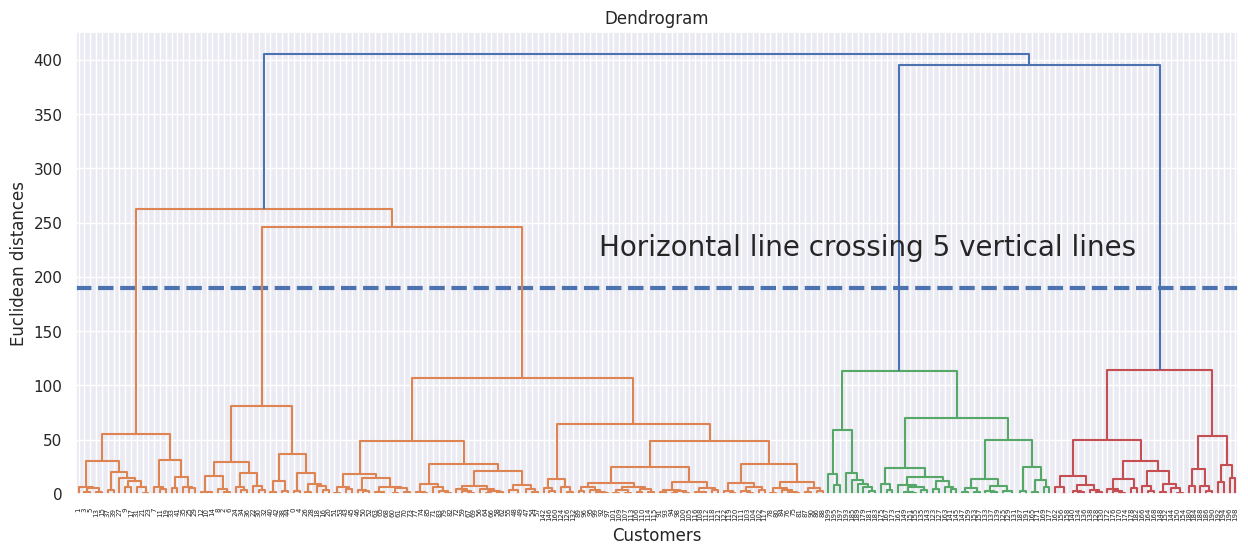

In [155]:
plt.figure(figsize=(15,6))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.hlines(y=190,xmin=0,xmax=2000,lw=3,linestyles='--')
plt.text(x=900,y=220,s='Horizontal line crossing 5 vertical lines',fontsize=20)
#plt.grid(True)
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.show()

### Build the model

In [156]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, metric = 'euclidean', linkage = 'ward')  # affinity
y_hc = hc.fit_predict(X)

### Plot the clusters and label customer types
* _Careful_ - high income but low spenders
* _Standard_ - middle income and middle spenders
* **_Target group_ - middle-to-high income and high spenders (should be targeted by the mall)**
* _Careless_ - low income but high spenders (should be avoided because of possible credit risk)
* _Sensible_ - low income and low spenders

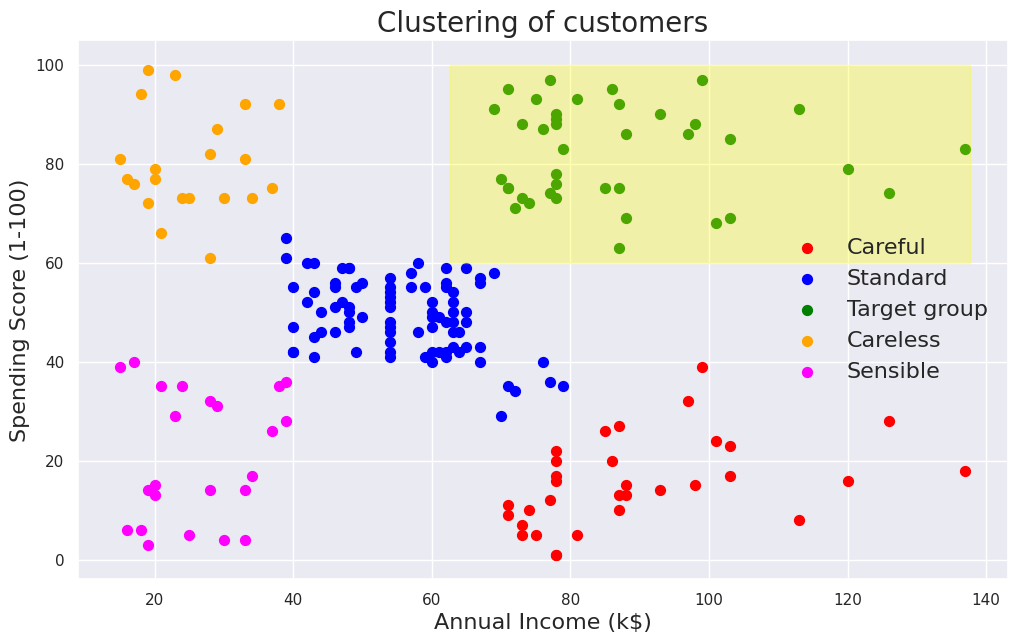

In [157]:
plt.figure(figsize=(12,7))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 50, c = 'red', label = 'Careful')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 50, c = 'blue', label = 'Standard')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 50, c = 'green', label = 'Target group')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 50, c = 'orange', label = 'Careless')
plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 50, c = 'magenta', label = 'Sensible')
plt.title('Clustering of customers',fontsize=20)
plt.xlabel('Annual Income (k$)',fontsize=16)
plt.ylabel('Spending Score (1-100)',fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.axhspan(ymin=60,ymax=100,xmin=0.4,xmax=0.96,alpha=0.3,color='yellow')
plt.show()

## Verifying the optimal number of clusters by k-means algorithm

Given a set of observations $(x_1, x_2, …, x_n)$, where each observation is a d-dimensional real vector, [**k-means clustering**](https://en.wikipedia.org/wiki/K-means_clustering) aims to partition the *$n$* observations into *$k$* (≤ *$n$*) sets $S = {S_1, S_2, …, S_k}$ so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance). Formally, the objective is to find:

$${\displaystyle {\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}\sum _{\mathbf {x} \in S_{i}}\left\|\mathbf {x} -{\boldsymbol {\mu }}_{i}\right\|^{2}={\underset {\mathbf {S} }{\operatorname {arg\,min} }}\sum _{i=1}^{k}|S_{i}|\operatorname {Var} S_{i}}$$

where $\mu_i$ is the mean of points in $S_i$

We run k-means++ model (k-means with carefully initialized centroids) iterating over number of clusters (1 to 15) and plot the ***within-cluster-sum-of-squares (WCSS) matric*** to determine the optimum number of cluster by elbow method

In [158]:
from sklearn.cluster import KMeans

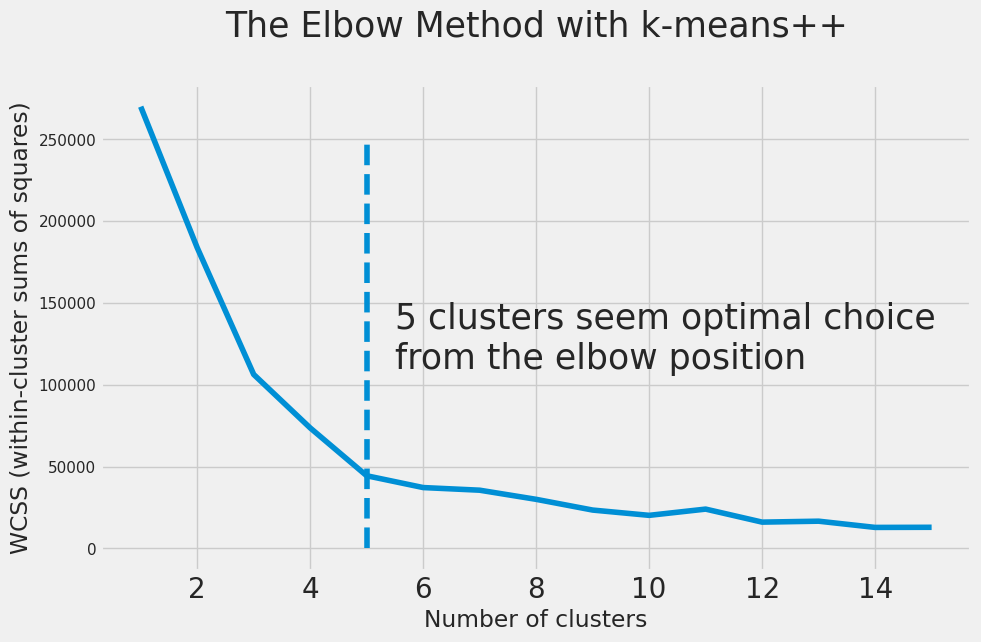

In [159]:
wcss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

with plt.style.context(('fivethirtyeight')):
    plt.figure(figsize=(10,6))
    plt.plot(range(1, 16), wcss)
    plt.title('The Elbow Method with k-means++\n',fontsize=25)
    plt.xlabel('Number of clusters')
    plt.xticks(fontsize=20)
    plt.ylabel('WCSS (within-cluster sums of squares)')
    plt.vlines(x=5,ymin=0,ymax=250000,linestyles='--')
    plt.text(x=5.5,y=110000,s='5 clusters seem optimal choice \nfrom the elbow position',
             fontsize=25) #,fontdict={'family':'Times New Roman'})
    plt.show()

## Examples

Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a variety of situations.
We'll now take a look at a couple of examples.

### Example 1: k-Means on Digits

To start, let's take a look at applying *k*-means on the same simple digits data that we saw in [Principal Component Analysis](PCA.ipynb).
Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the dataset, then find the clusters.
Recall that the digits dataset consists of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8 × 8 image:

In [49]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [50]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can be interpreted as representing the "typical" digit within the cluster.
Let's see what these cluster centers look like (see the following figure):

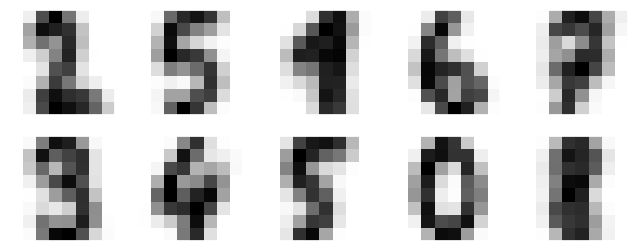

In [51]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because *k*-means knows nothing about the identities of the clusters, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in the clusters:

In [52]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [53]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7440178074568725

With just a simple *k*-means algorithm, we discovered the correct grouping for 74% of the input digits!
Let's check the confusion matrix for this, visualized in the following figure:

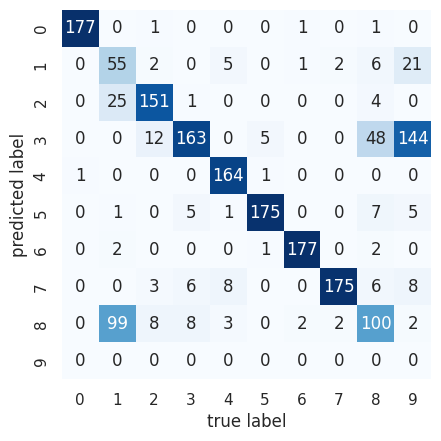

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!

Just for fun, let's try to push this even farther.
We can use the t-distributed stochastic neighbor embedding algorithm (mentioned in [Manifold Learning](Manifold-Learning.ipynb)) to preprocess the data before performing *k*-means.
t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.
Let's see how it does:

In [55]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random',
            learning_rate='auto',random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9415692821368948

That's a 94% classification accuracy *without using the labels*.
This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to extract by hand or by eye.

### Example 2: k-Means for Color Compression

One interesting application of clustering is in color compression within images (this example is adapted from Scikit-Learn's ["Color Quantization Using K-Means"](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html).
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn `datasets` module (for this to work, you'll have to have the `PIL` Python package installed):
(For a color version of this and following images, see the online version of this book).

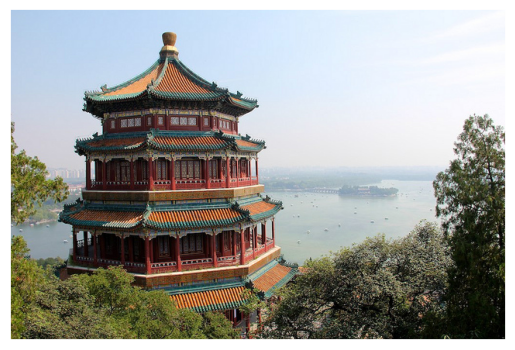

In [56]:
# Note: this requires the PIL package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size `(height, width, RGB)`, containing red/blue/green contributions as integers from 0 to 255:

In [62]:
china.shape


(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to `[n_samples, n_features]` and rescale the colors so that they lie between 0 and 1:

In [63]:
data = china / 255.0  # use 0...1 scale
data = data.reshape(-1, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency (see the following figure):

In [66]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data

    # choose a random subset
    rng = np.random.default_rng(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

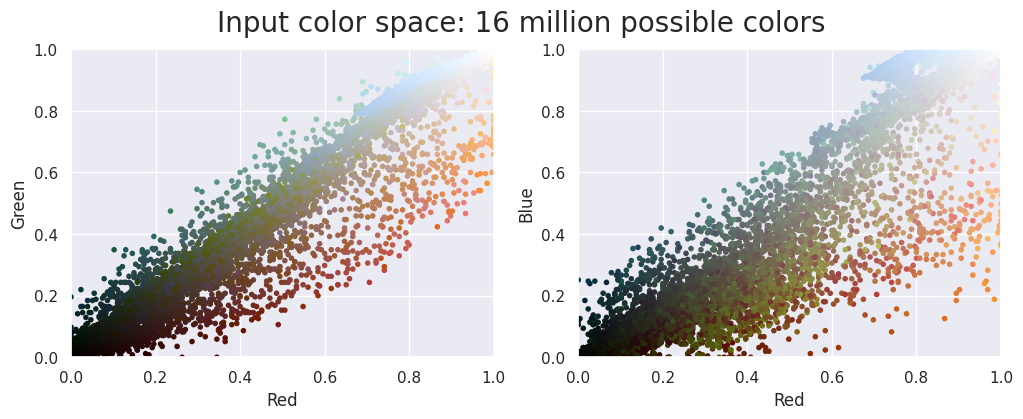

In [67]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 32 colors, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini-batch *k*-means, which operates on subsets of the data to compute the result (shown in the following figure) much more quickly than the standard *k*-means algorithm:

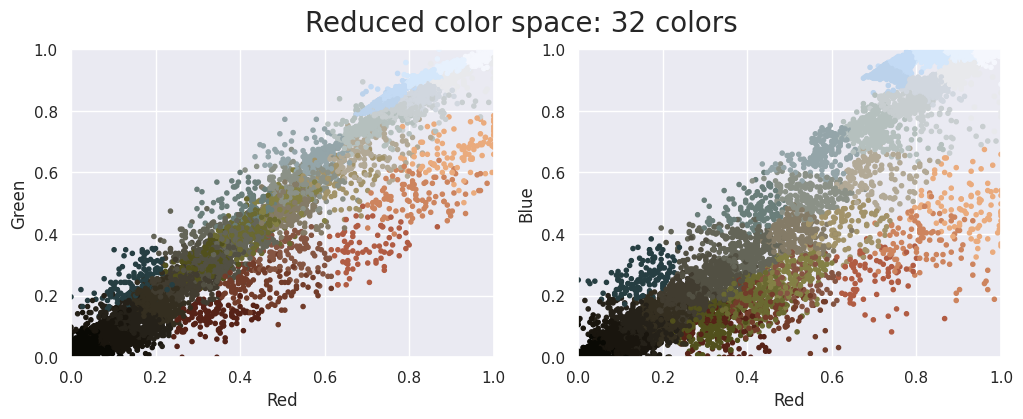

In [82]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(32)
kmeans.fit(data)
# replace the color of every pixel with the color cluster center.
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 32 colors")

The result is a recoloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this (see the following figure):

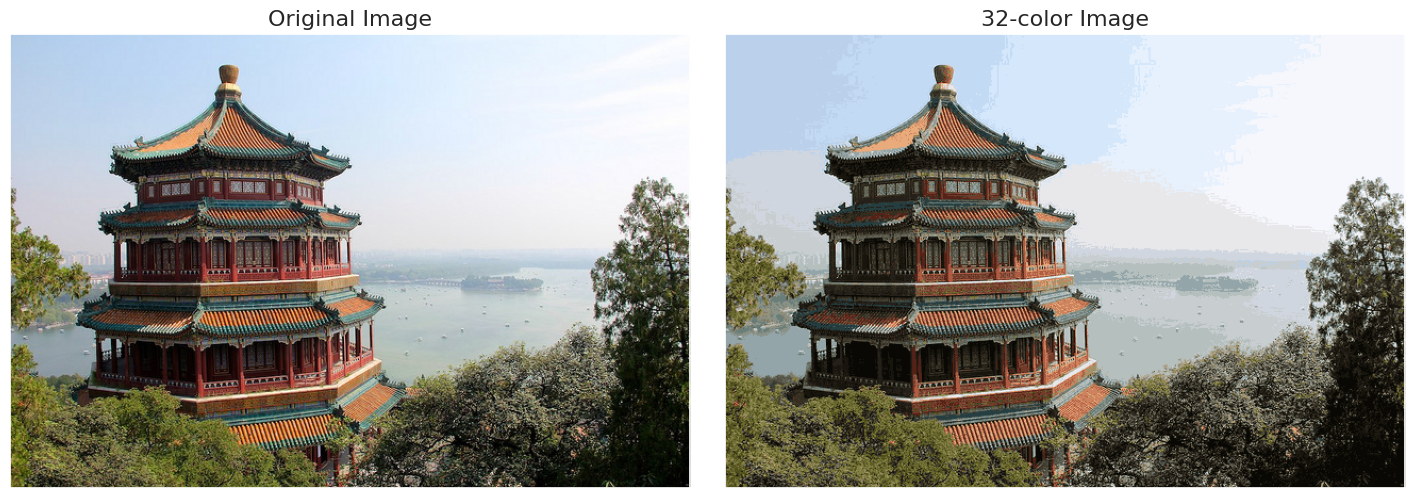

In [83]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(18, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('32-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable.
In terms of the bytes required to store the raw data, the image on the right achieves a compression factor of around 1 million!
Now, this kind of approach is not going to match the fidelity of purpose-built image compression schemes like JPEG, but the example shows the power of thinking outside of the box with unsupervised methods like *k*-means.